# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import ConstantPopulationSize, AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           calculate_parameter_sensitivity,
                           plot_parameter_sensitivity,
                           plot_regression_fit,
                           plot_distance_weights,
                           plot_sim_results,
                           plot_parameters_kde)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [5]:
from channels.ina_generic import ina as model
model.sample({})

,x,y,exp
0,-90.000000,-5.261781e-06,0
1,-80.000000,-4.893529e-04,0
2,-70.000000,-4.347802e-02,0
3,-60.000000,-3.229473e+00,0
4,-50.000000,-1.252228e+02,0
5,-40.000000,-1.116509e+03,0
6,-30.000000,-2.261101e+03,0
7,-20.000000,-2.303820e+03,0
8,-10.000000,-1.767243e+03,0
9,0.000000,-9.007919e+02,0


# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [7]:
limits = dict(g_Na=(0, 100),
              Vhalf_m=(-100,100),
              k_m=(0,50),
              c_bm=(0,0.1),
              c_am=(0,1),
              Vmax_m=(-100,0),
              sigma_m=(0,50),
              Vhalf_h=(-100,0),
              k_h=(-50,0),
              c_bh=(0,0.1),
              c_ah=(0,50),
              Vmax_h=(-100,0),
              sigma_h=(0,50),
              c_bj=(0,10),
              c_aj=(50,100),
              Vmax_j=(-100,0),
              sigma_j=(0,50))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [8]:
parameters = ['ina.'+k for k in limits.keys()]

In [9]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

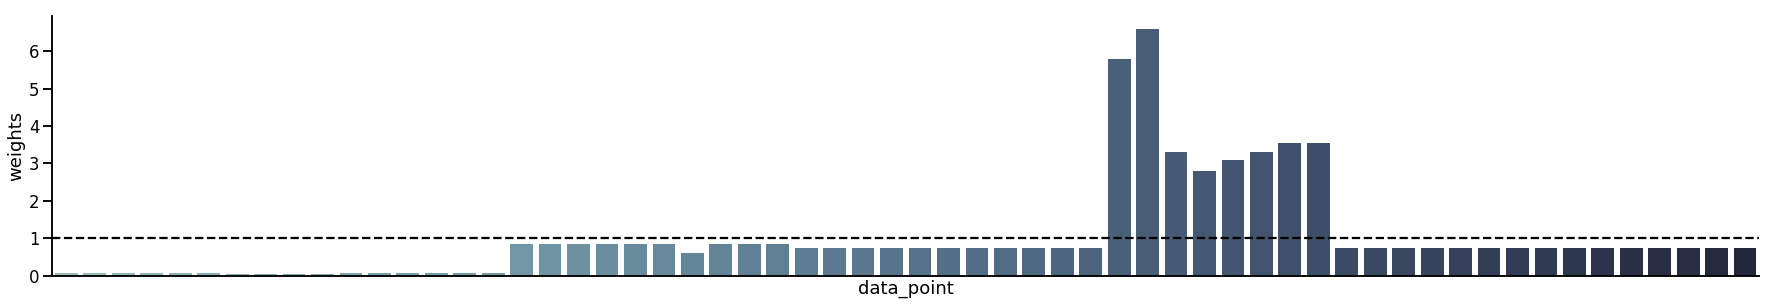

In [10]:
sns.set_context('talk')
g = plot_distance_weights(model, distance_fn)
g.savefig('results/ina-generic/dist_weights.pdf')

In [14]:
fitted, regression_fit, r2 = calculate_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.05,
    n_samples=1000)

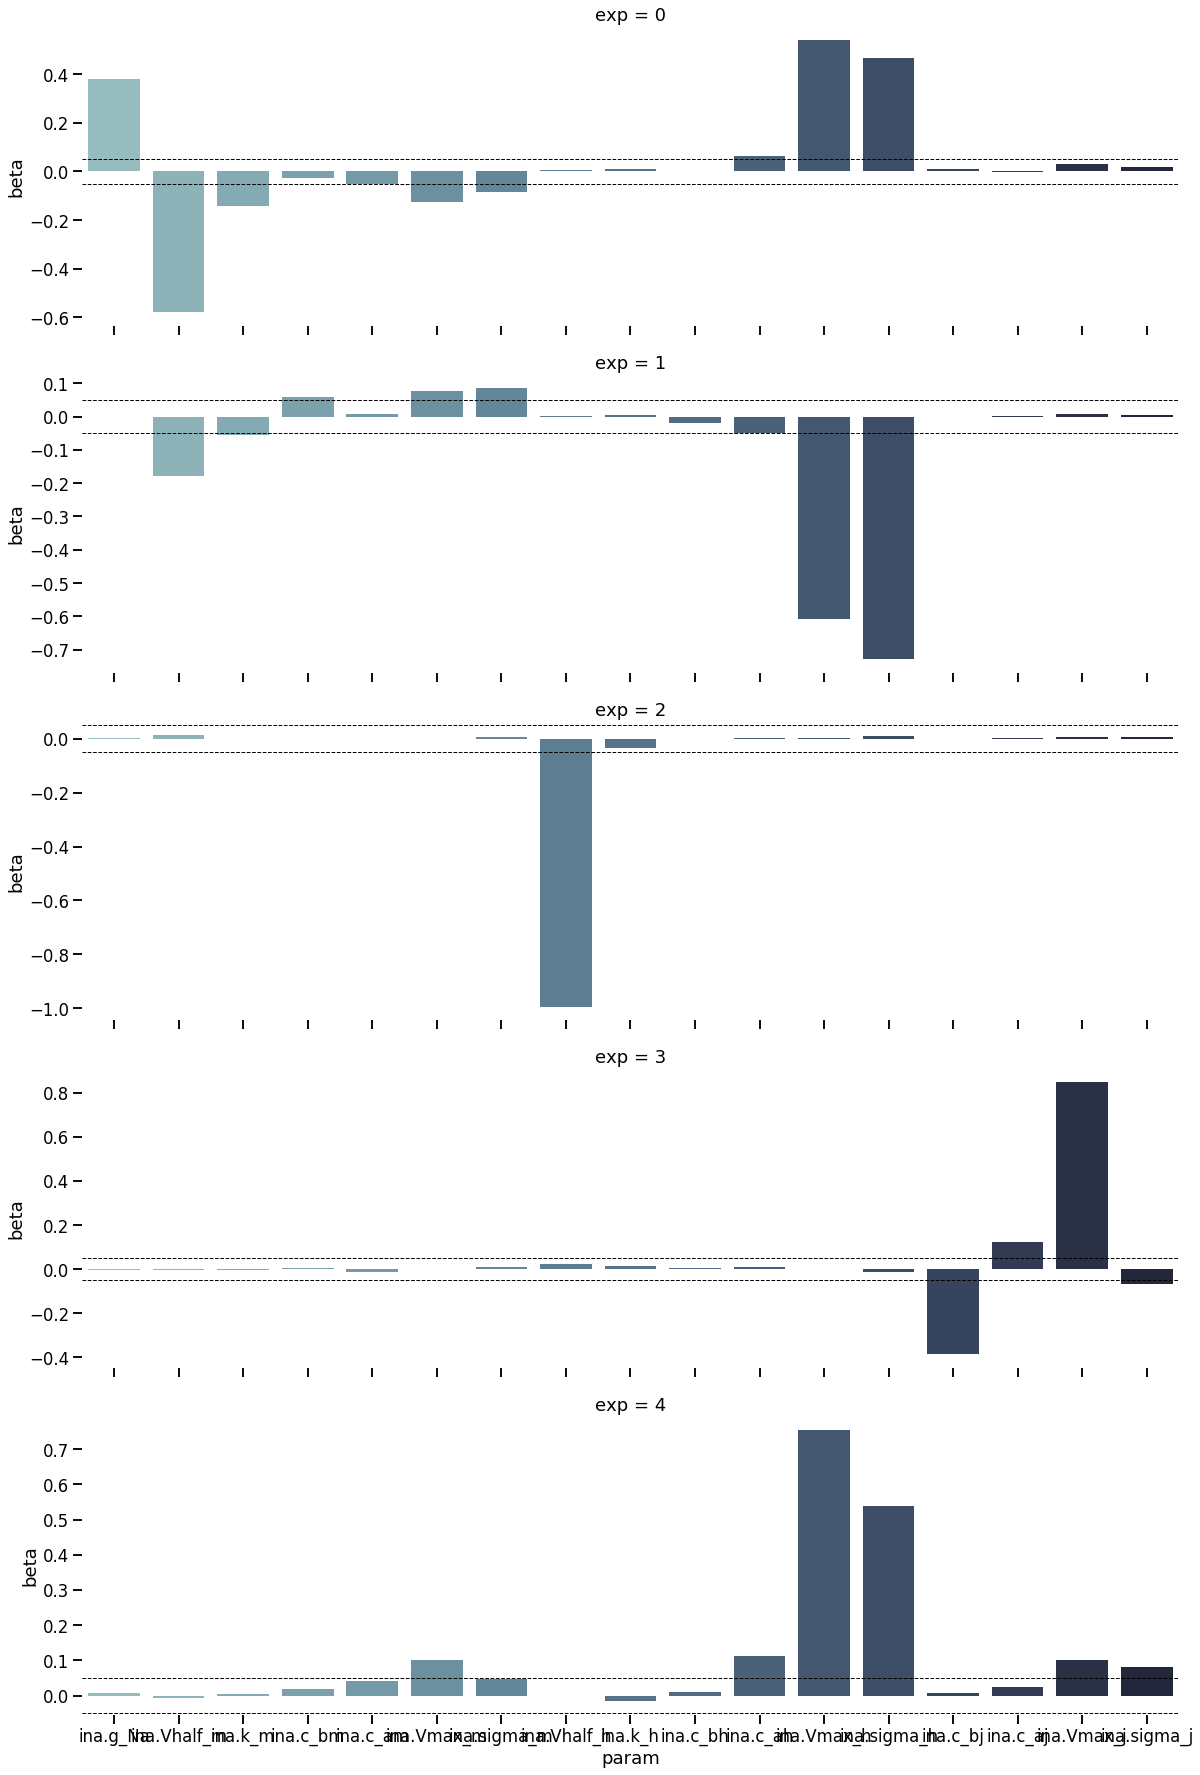

In [15]:
sns.set_context('talk')
grid1 = plot_parameter_sensitivity(fitted, plot_cutoff=0.05)

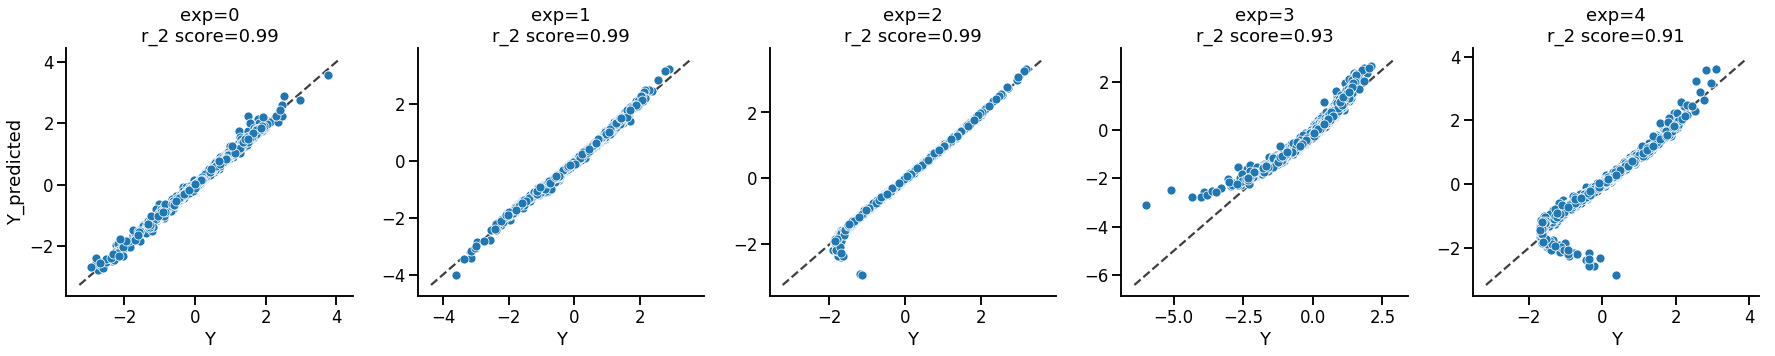

In [16]:
grid2 = plot_regression_fit(regression_fit, r2)

In [17]:
grid1.savefig('results/ina-generic/sensitivity.pdf')
grid2.savefig('results/ina-generic/sensitivity_fit.pdf')

In [32]:
# Finding insensitive parameters
cutoff = 0.05
fitted_pivot = fitted.pivot(index='param',columns='exp')
insensitive_params = fitted_pivot[(abs(fitted_pivot['beta'][0])<cutoff) & (abs(fitted_pivot['beta'][1])<cutoff) &
             (abs(fitted_pivot['beta'][2])<cutoff) & (abs(fitted_pivot['beta'][3])<cutoff) &
             (abs(fitted_pivot['beta'][4])<cutoff)].index.values

In [42]:
insensitive_params

array(['ina.Vmax_h', 'ina.Vmax_m', 'ina.c_ah', 'ina.c_aj', 'ina.c_am',
       'ina.k_h', 'ina.sigma_h', 'ina.sigma_m'], dtype=object)

In [43]:
insensitive_params = np.delete(insensitive_params,5)

In [91]:
insensitive_params

array(['ina.Vmax_h', 'ina.Vmax_m', 'ina.c_ah', 'ina.c_aj', 'ina.c_am',
       'ina.sigma_h', 'ina.sigma_m'], dtype=object)

In [92]:
insensitive_limits = dict((k, limits[k[4:]]) for k in insensitive_params)
insensitive_prior = Distribution(**{key: RV("uniform", a, b - a)
                                 for key, (a,b) in insensitive_limits.items()})

In [93]:
# Generate random samples for insensitive parameters
def generate_sample(insensitive_prior, n):
    samples = [dict() for i in range(n)]
    for i in range(n):
        parameters = insensitive_prior.rvs()
        sample = {key: value for key, value in parameters.items()}
        samples[i].update(sample)
    return samples

In [94]:
samples = generate_sample(insensitive_prior, 1000)

In [95]:
model.add_external_par_samples(samples)

In [96]:
limits = dict((k, limits[k]) for k in limits if 'ina.'+k not in insensitive_params)

In [97]:
limits

{'g_Na': (0, 100),
 'Vhalf_m': (-100, 100),
 'k_m': (0, 50),
 'c_bm': (0, 0.1),
 'Vhalf_h': (-100, 100),
 'k_h': (-50, 0),
 'c_bh': (0, 10),
 'c_bj': (0, 50),
 'Vmax_j': (-500, 500),
 'sigma_j': (0, 500)}

In [8]:
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Initialise pyabc database

In [18]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ina-generic.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ina-generic.db


In [19]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [20]:
from pyabc.populationstrategy import ConstantPopulationSize

In [22]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=ConstantPopulationSize(5000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=1000,
             #    mean_cv=0.2,
             #    max_population_size=1000,
             #    min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=24),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.05482047444775661, 1: 0.05482047444775661, 2: 0.05482047444775661, 3: 0.05482047444775661, 4: 0.05482047444775661, 5: 0.05482047444775661, 6: 0.04793030963340064, 7: 0.04260405991323703, 8: 0.0479278046958729, 9: 0.0536798519659175, 10: 0.05482047444775661, 11: 0.05482047444775661, 12: 0.05482047444775661, 13: 0.05482047444775661, 14: 0.05482047444775661, 15: 0.05482047444775661, 16: 0.8326197611814873, 17: 0.8326197611814873, 18: 0.8326197611814873, 19: 0.8326197611814873, 20: 0.8326197611814873, 21: 0.8326197611814873, 22: 0.6017669628485173, 23: 0.8326197611814873, 24: 0.8326197611814873, 25: 0.8326197611814873, 26: 0.7463215252566501, 27: 0.7463215252566501, 28: 0.7463215252566501, 29: 0.7463215252566501, 30: 0.7463215252566501, 31: 0.7463215252566501, 32: 0.7463215252566501, 33: 0.7463215252566501, 34: 0.7463215252566501, 35: 0.7463215252566501, 36: 0.7463215252566501, 37: 5.779317930650152, 38: 6.604934777885866, 39: 3.3021281756664393, 40: 2.

In [23]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=3, start_time=2018-11-22 09:16:28.202515, end_time=None)>
INFO:Epsilon:initial epsilon is 18.61251595376843


In [ ]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:18.61251595376843
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 9720
DEBUG:Epsilon:new eps, t=1, eps=17.91243680999823
INFO:ABC:t:1 eps:17.91243680999823
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 21478
DEBUG:Epsilon:new eps, t=2, eps=15.78498886783122
INFO:ABC:t:2 eps:15.78498886783122
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 35019
DEBUG:Epsilon:new eps, t=3, eps=12.894478319692608
INFO:ABC:t:3 eps:12.894478319692608
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 51522
DEBUG:Epsilon:new eps, t=4, eps=10.930297596402498
INFO:ABC:t:4 eps:10.930297596402498
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 73963
DEBUG:Epsilon:new eps, t=5, eps=

In [ ]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=30, min_acceptance_rate=0.005)

# Results analysis

In [26]:
db_path = 'sqlite:////scratch/cph211/tmp/hl-1_ina-generic.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-11-21 18:07:43.181769, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-11-21 18:08:20.821265, end_time=2018-11-22 03:12:32.743491)>]

In [27]:
history.id = 2

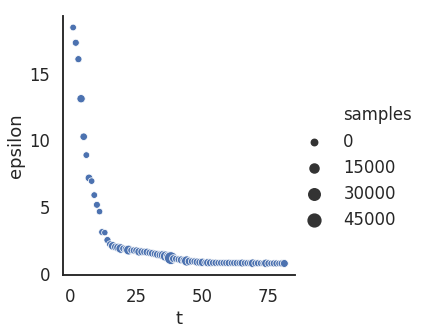

In [28]:
sns.set_context('talk')
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=1])
#grid.savefig('results/ina/eps_evolution.pdf')

In [29]:
df, w = history.get_distribution(m=0)

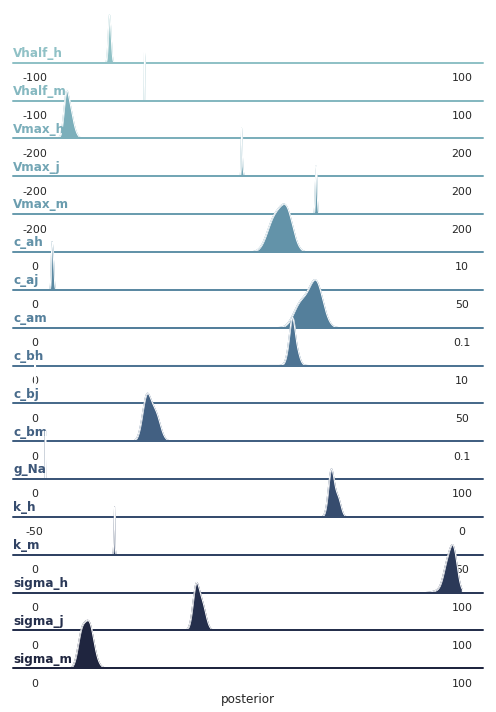

In [30]:
g = plot_parameters_kde(df, w, limits, aspect=12, height=0.6)

In [20]:
#g.savefig('results/ina/parameters_kde.pdf')

# Samples for quantitative analysis

In [31]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [32]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th)#, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

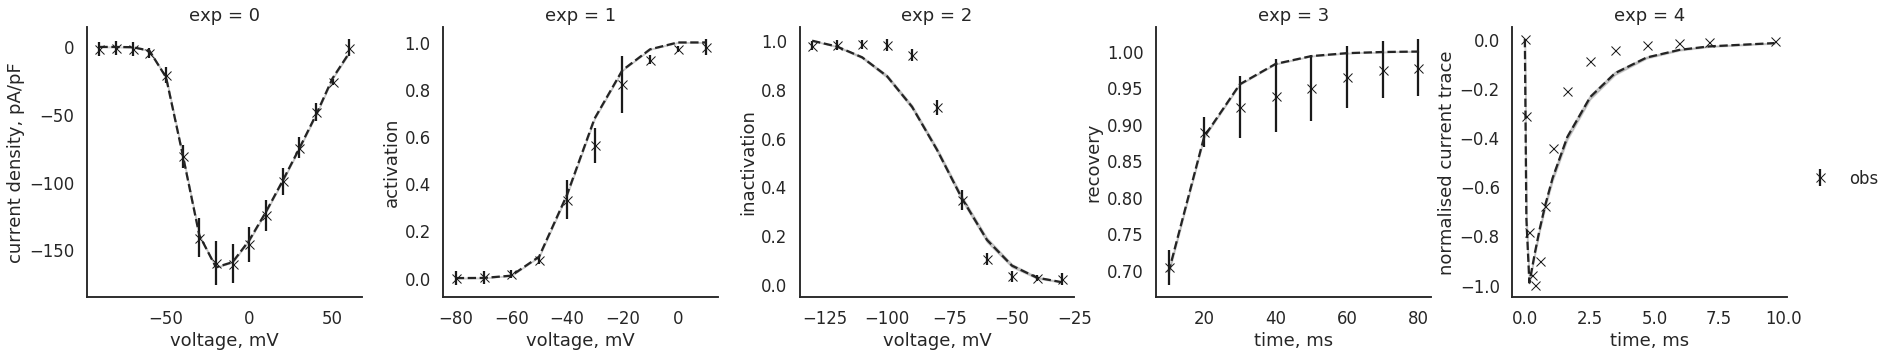

In [33]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms"]
ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current trace"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [27]:
g.savefig('results/ina/ina_sim_results.pdf')

In [28]:
# Require discrete samples for exact measurements at -20mV
discrete_samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th)
    output['sample'] = i
    output['distribution'] = 'post'
    discrete_samples = discrete_samples.append(output, ignore_index=True)

In [29]:
# Amplitude at -20 mV
grouped = discrete_samples[discrete_samples['exp']==0].groupby('sample')
def get_amplitude(group):
    return group.loc[group.x==-20]['y']
print(grouped.apply(get_amplitude).mean())
print(grouped.apply(get_amplitude).std())

-160.90196264352795
5.971638842006106
The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [31]:
import scipy.stats as st
peak_current = discrete_samples[discrete_samples['exp']==0].groupby('sample').apply(get_amplitude).tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -160.49427334631037
95% CI: (-173.4232959055239, -149.88858494085878)


In [32]:
# Voltage and slope factor at half-activation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((Vhalf-V)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [33]:
print(output.mean())
print(output.std())

0   -35.198870
1     7.077036
dtype: float64
0    1.077150
1    0.895428
dtype: float64


In [34]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -35.297432069439395
95% CI: (-37.16992916736465, -33.00366784635306)


In [35]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 7.0123915573204245
95% CI: (5.335717755624719, 8.748525607464313)


In [36]:
# Voltage and slope factor at half-inactivation
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((V-Vhalf)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [37]:
print(output.mean())
print(output.std())

0   -70.387098
1     5.516439
dtype: float64
0    16.941384
1     0.699928
dtype: float64


In [38]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -73.05940272441362
95% CI: (-100.18293538638304, -34.65451029256239)


In [39]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.194922877406126
95% CI: (4.403575801992869, 6.9820518074314295)
